<a href="https://colab.research.google.com/github/fastdatascience/clinical_trial_risk/blob/fixes_nov_2022/train/ctgov/TrainSAPClassifier_04_NaiveBayes_fixed_vocab_smaller.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import spacy
import pandas as pd
import re
import os
import sys
import pickle as pkl
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, auc, roc_curve
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_annotations = pd.read_csv("/content/drive/MyDrive/data/all_annotations.csv")


# Get data

In [4]:
stats_vocab = set("""0	pe
1	sap
2	tabulated
3	hazard
4	inferiority
5	categorical
6	meddra
7	residual
8	itt
9	continuous
10	summarised
11	variables
12	brv
13	variable
14	cox
16	laz
17	statistics
18	descriptive
19	regression
20	proportional
21	hazards
22	sided
23	deviation
26	percentage
27	calculated
28	analysed
29	censored
30	derived
31	coding
32	cumulative
34	soc
38	covariates
39	survival
40	deviations
41	pv
42	interim
43	class
44	hypothesis
45	sensitivity
46	power
47	ratio
48	summarized
49	median
50	measurements
51	model
52	endpoint
53	exploratory
54	statistical
55	plan
56	confidence
57	log
58	ipm
59	estimate
60	planned
62	classified
63	95%
64	solicited
65	iu
66	significance
67	adjusted
68	pq
69	randomisation
70	ci
71	values
72	differences
73	measures
74	signed
75	outcomes
76	assigned
77	analyses
78	overview
79	intervals
81	measurement
82	90%
83	versus
84	analysis
85	point
86	adherence
87	interval
88	secondary
89	value
90	groups
91	estimated
92	mean
93	relative
94	treat
95	frequency
96	outcome
97	detect
98	discharge
99	distribution
100	baseline
101	endpoints
102	dsmb
103	objectives
104	efficacy
105	method
106	negative
112	ae
113	rate
116	cd
119	parameters
120	maximum
123	crf
124	type
126	incidence
127	defined
128	function
129	50%
152	vs
155	database
156	effect
159	saes
169	one
173	two
178	observed
179	version
180	measure
182	three
202	design
265	sample
282	criteria
283	examination
284	evaluated
286	similar
312	control
325	sae
394	50
426	95
447	90
462	records
465	management
473	documents
478	access
490	55""".split("\n"))
stats_vocab = set([re.sub(r'^\d+\s+', '', w) for w in stats_vocab])

In [5]:
tok = RegexpTokenizer(r'[a-zA-Z]+')

In [6]:
with open("/content/drive/MyDrive/data/protocols.pkl.gz", "rb") as f:
    file_to_pages = pkl.load(f)

In [7]:
import operator
texts = []

for i in range(len(df_annotations)):
    file_name = df_annotations.file.iloc[i]
    
    pages= file_to_pages[file_name]

    texts.append(" ".join(pages))
df_annotations["text"] = texts

In [8]:
 del file_to_pages

In [9]:
df_annotations = df_annotations[~df_annotations.has_sap.isna()]

In [10]:
df_annotations["has_sap"].value_counts()

0    6150
1    5774
Name: has_sap, dtype: int64

In [11]:
df_train = df_annotations[df_annotations.train_val == "train"]
df_val = df_annotations[df_annotations.train_val == "val"]

In [12]:

# Specially engineered regex to include 95%, 95%ci, etc
vectoriser = CountVectorizer(lowercase=True, vocabulary=stats_vocab, min_df=5,
                             token_pattern=r'[59][05]%?(?:ci)?|[a-z][a-z]+')
transformer = TfidfTransformer()

nb = MultinomialNB()
model = make_pipeline(vectoriser, transformer, nb)

In [13]:
df_train_small = df_train.sample(100)

In [14]:
model.fit(df_train.text, df_train.has_sap)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(min_df=5,
                                 token_pattern='[59][05]%?(?:ci)?|[a-z][a-z]+',
                                 vocabulary={'50', '50%', '55', '90', '90%',
                                             '95', '95%', 'access', 'adherence',
                                             'adjusted', 'ae', 'analysed',
                                             'analyses', 'analysis', 'assigned',
                                             'baseline', 'brv', 'calculated',
                                             'categorical', 'cd', 'censored',
                                             'ci', 'class', 'classified',
                                             'coding', 'confidence',
                                             'continuous', 'control',
                                             'covariates', 'cox', ...})),
                ('tfidftransformer', TfidfTransformer()),
                ('multinom

In [28]:
df_val["y_pred"] = model.predict(df_val.text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [29]:
df_val["y_pred_proba"] = model.predict_proba(df_val.text)[:,1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [30]:
sap_ground_truths = df_val.has_sap
pred_sap = df_val.y_pred

In [31]:
acc = accuracy_score(sap_ground_truths, pred_sap)
print (f"SAP accuracy {acc}")

SAP accuracy 0.7972350230414746


''

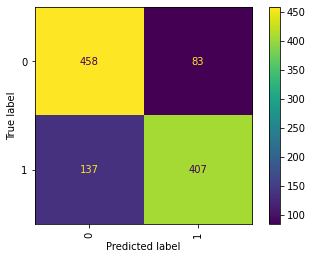

In [32]:
ConfusionMatrixDisplay.from_predictions(sap_ground_truths, pred_sap)
plt.xticks(rotation=90)
;

In [33]:
all_aucs = []
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(sap_ground_truths, df_val["y_pred_proba"])
print (f"SAP ROC AUC {roc_auc}")

SAP ROC AUC 0.8550750244644993


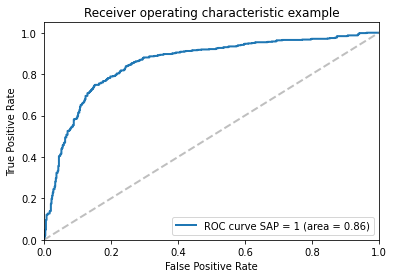

In [34]:
plt.figure()
lw = 2
    
for i in [1]:
    fpr, tpr, _ = roc_curve(sap_ground_truths, df_val["y_pred_proba"])
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        # color="darkorange",
        lw=lw,
        label=f"ROC curve SAP = {i} (area = {roc_auc:0.2f})"
    )
    plt.plot([0, 1], [0, 1], color="gray", alpha=0.5, lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [35]:
fake_document = " ".join(vectoriser.vocabulary_)
vectorised_document = vectoriser.transform([fake_document])
transformed_document = transformer.transform(vectorised_document)
probas = np.zeros((transformed_document.shape[1]))

for prediction_idx in [1]:
      print(f"Strongest predictors for class {prediction_idx}\n")
      for i in range(transformed_document.shape[1]):
          zeros = np.zeros(transformed_document.shape)
          zeros[0, i] = transformed_document[0, i]
          proba = nb.predict_log_proba(zeros)
          probas[i] = proba[0, prediction_idx]

      for ctr, j in enumerate(np.argsort(-probas)):
          for w, i in vectoriser.vocabulary_.items():
              if i == j:
                  print(f"{ctr}\t{w}")


Strongest predictors for class 1

0	dsmb
1	cox
2	regression
3	survival
4	residual
5	detect
6	differences
7	cd
8	hypothesis
9	estimate
10	vs
11	power
12	pq
13	cumulative
14	three
15	50%
16	outcomes
17	two
18	versus
19	proportional
20	adherence
21	effect
22	measure
23	plan
24	similar
25	function
26	discharge
27	median
28	sensitivity
29	distribution
30	incidence
31	pv
32	measures
33	groups
34	significance
35	continuous
36	control
37	one
38	outcome
39	treat
40	negative
41	type
42	rate
43	management
44	95
45	derived
46	covariates
47	50
48	measurement
49	version
50	iu
51	access
52	95%
53	variable
54	database
55	evaluated
56	frequency
57	90
58	model
59	estimated
60	55
61	statistical
62	adjusted
63	confidence
64	secondary
65	design
66	log
67	90%
68	criteria
69	calculated
70	deviation
71	variables
72	categorical
73	assigned
74	classified
75	observed
76	measurements
77	point
78	hazards
79	objectives
80	coding
81	soc
82	mean
83	analysis
84	intervals
85	signed
86	hazard
87	deviations
88	sample
89	

In [38]:
import bz2
with bz2.open("sap_classifier_document_level.pkl.bz2", "wb") as f:
    pkl.dump(model, f)

In [37]:
1

1